# 3. Model proposals - DF2 (662x12)

LDA, QDA, K-NN, Naive Bayes, Logistic Regression, Decision Trees and Random Forests

### Libraries and data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
from sklearn.decomposition import PCA
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, KFold,
    cross_validate
)
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, Lasso
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
import scipy.stats as stats
from scipy.stats import boxcox
from pandas.api.types import CategoricalDtype

from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
)
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
from IPython.core.interactiveshell import InteractiveShell
from sklearn.tree import DecisionTreeClassifier
#import graphviz
from sklearn.tree import export_graphviz
from sklearn.ensemble import (
    RandomForestClassifier, VotingClassifier, GradientBoostingClassifier,
    StackingClassifier, ExtraTreesClassifier
)
from imblearn.under_sampling import RandomUnderSampler
from time import time
from datetime import timedelta

InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.precision', 3)
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
DF2 = pd.read_pickle('RiskFactors_processed.pkl.bz2',compression='bz2')

In [3]:
X = DF2.drop('Cancer', axis=1)  # Features
y = DF2['Cancer']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and fit the Lasso regression model
lasso = Lasso(alpha=0.001)  # Adjust the alpha parameter as needed
lasso.fit(X_train, y_train)

# Get the coefficients and corresponding feature names
coefficients = pd.Series(lasso.coef_, index=X_train.columns)

# Select the features with non-zero coefficients
selected_features = coefficients[coefficients != 0].index.tolist()

selected_features += ['Cancer']

# Print the selected features
print("Selected features:")
print(selected_features)

Lasso(alpha=0.001)

Selected features:
['Age', 'Number of sexual partners', 'First sexual intercourse', 'Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs:condylomatosis', 'STDs:HIV', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Cancer']


In [4]:
DF2 = DF2[selected_features]
DF2.head()
DF2.shape
numerical_columns = ['Age', 'Number of sexual partners', 'First sexual intercourse']
categorical_columns = ['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs:condylomatosis', 'STDs:HIV', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV']

# Load the dataset and split into train, test, and validation sets
X = DF2.iloc[:, :-1]  # Features (all columns except the last one)
y = DF2['Cancer']  # Target variable (last column)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Apply resampling techniques to handle class imbalance
undersampler = RandomUnderSampler(sampling_strategy=0.8)  # Adjust the sampling strategy as needed
X_train, y_train = undersampler.fit_resample(X_train, y_train)

,Age,Number of sexual partners,First sexual intercourse,Smokes,Hormonal Contraceptives,IUD,STDs:condylomatosis,STDs:HIV,Dx:Cancer,Dx:CIN,Dx:HPV,Cancer
0,0.901,0.758,0.539,0,1,0,0,0,0,0,0,0
1,0.746,0.851,0.539,1,1,0,0,0,0,0,0,0
2,0.514,0.314,0.804,0,1,0,0,0,0,0,0,0
3,0.685,0.506,0.804,1,1,0,0,0,0,0,0,1
4,0.663,0.314,0.652,0,1,0,0,0,0,0,0,0


(662, 12)

In [5]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

In [6]:
def compute_metrics(y_real,y_pred):
    # By default it will compute the binary recall of class 1, we can specify which class do we want by using this parameter 
    recall_class_1 =recall_score(y_real,y_pred, pos_label=1)
    f1_class_1 =f1_score(y_real,y_pred, pos_label=1)
    accuracy = accuracy_score(y_real,y_pred)
    f1_macro =f1_score(y_real,y_pred, average='macro')
    precison_macro =precision_score(y_real,y_pred,  average='macro')
    recall_macro =recall_score(y_real,y_pred,  average='macro')
    return [recall_class_1, f1_class_1, accuracy,f1_macro,precison_macro,recall_macro ]

In [7]:
results = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])


### TRAIN TEST VAL RESAMPLING (significantly worse than undersampling, won't be considered)

#### LDA

In [8]:
X = DF2.loc[:,DF2.columns != 'Cancer']
y = DF2['Cancer']

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
X_train.shape
X_val.shape
X_test.shape
y_train.shape
y_val.shape
y_test.shape

(396, 11)

(133, 11)

(133, 11)

(396,)

(133,)

(133,)

In [9]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)


print('Priors:', lda_model.priors_)
print('Means:\n')
means = pd.DataFrame(lda_model.means_)
means.columns = DF2.columns[:-1]  # Exclude the target variable
means.index = lda_model.classes_
means

print('Coefficients:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = DF2.columns[:-1]  # Exclude the target variable
coefs.index = [0]  # Set a single index value for binary classification
coefs.T

print('Intercepts:')
intercepts = pd.DataFrame(lda_model.intercept_)
intercepts.index = [0]  # Set a single index value for binary classification
intercepts

print('Explained Variance Ratio:')
explained_variance_ratio = pd.DataFrame(lda_model.explained_variance_ratio_)
explained_variance_ratio

LinearDiscriminantAnalysis()

Priors: [0.87121212 0.12878788]
Means:



,Age,Number of sexual partners,First sexual intercourse,Smokes,Hormonal Contraceptives,IUD,STDs:condylomatosis,STDs:HIV,Dx:Cancer,Dx:CIN,Dx:HPV
0,0.501,0.354,0.636,0.125,0.652,0.101,0.029,0.012,0.023,0.003,0.020
1,0.551,0.386,0.642,0.196,0.686,0.216,0.176,0.059,0.098,0.020,0.098


Coefficients:


,0
Age,0.739
Number of sexual partners,0.165
First sexual intercourse,0.253
Smokes,0.575
Hormonal Contraceptives,0.191
IUD,0.842
STDs:condylomatosis,3.392
STDs:HIV,2.390
Dx:Cancer,0.299
Dx:CIN,4.257


Intercepts:


,0
0,-3.54


Explained Variance Ratio:


,0
0,1.0


In [10]:
confusion(pd.Series(y_val), pd.Series(y_pred_lda))

predicted,0,1
target,,
0,105,11
1,13,4


In [11]:
print(classification_report(y_val, y_pred_lda))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       116
           1       0.27      0.24      0.25        17

    accuracy                           0.82       133
   macro avg       0.58      0.57      0.57       133
weighted avg       0.81      0.82      0.81       133



In [12]:
results = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results.loc['LDA', :] = compute_metrics(y_val, y_pred_lda)
results

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.235,0.25,0.82,0.574,0.578,0.57


#### QDA

In [13]:
import warnings
warnings.filterwarnings("ignore")

index= pd.MultiIndex.from_arrays([[], []], names=('model', 'reg'));
results_qda = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro']);

regularization_parameters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1];

for reg in regularization_parameters:
    qda_model = QuadraticDiscriminantAnalysis(reg_param=reg);
    qda_model = qda_model.fit(X_train,y_train);
    y_pred = qda_model.predict(X_val);
    results_qda.loc[('QDA',reg), :] = compute_metrics(y_val, y_pred);

results_qda.sort_values(by='**Recall class 1**', ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro  \
model reg                                                             
QDA   0.000e+00              0.353          0.179    0.586    0.451   
      1.000e-04              0.235          0.242    0.812    0.568   
      1.000e-03              0.235          0.242    0.812    0.568   
      1.000e-02              0.235          0.242    0.812    0.568   
      1.000e-01              0.176          0.261    0.872    0.595   
      5.000e-01                0.0            0.0    0.872    0.466   
      1.000e+00                0.0            0.0    0.872    0.466   

                Precision Macro Recall Macro  
model reg                                     
QDA   0.000e+00           0.494        0.487  
      1.000e-04           0.569        0.566  
      1.000e-03           0.569        0.566  
      1.000e-02           0.569        0.566  
      1.000e-01           0.695        0.575  
      5.000e-01           0.436          0.5  
      1.000e+00           0.436          0.5

In [14]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=0.0001);
qda_model = qda_model.fit(X_train,y_train);
y_pred_qda = qda_model.predict(X_val);

In [15]:
confusion(pd.Series(y_val), pd.Series(y_pred_qda))

predicted,0,1
target,,
0,104,12
1,13,4


In [16]:
results.loc['QDA-0.0001', :] = compute_metrics(y_val, y_pred_qda)
results

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.235,0.25,0.82,0.574,0.578,0.57
QDA-0.0001,0.235,0.242,0.812,0.568,0.569,0.566


#### $k$-NN

In [17]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'));
results_knn = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

k_values = range(1,50,2);

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k);
    knn = knn.fit(X_train,y_train);
    y_pred = knn.predict(X_val);
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred);

results_knn.sort_values(by='**Recall class 1**',ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro Precission Macro  \
model k                                                                         
KNN   1               0.176            0.2     0.82    0.549            0.557   
      5               0.118            0.2     0.88    0.567            0.776   
      7               0.059          0.105    0.872    0.518            0.689   
      3               0.059           0.08    0.827    0.492            0.498   
      29                0.0            0.0    0.872    0.466            0.436   
      47                0.0            0.0    0.872    0.466            0.436   
      45                0.0            0.0    0.872    0.466            0.436   
      43                0.0            0.0    0.872    0.466            0.436   
      41                0.0            0.0    0.872    0.466            0.436   
      39                0.0            0.0    0.872    0.466            0.436   
      37                0.0            0.0    0.872    0.466            0.436   
      35                0.0            0.0    0.872    0.466            0.436   
      33                0.0            0.0    0.872    0.466            0.436   
      31                0.0            0.0    0.872    0.466            0.436   
      25                0.0            0.0    0.872    0.466            0.436   
      27                0.0            0.0    0.872    0.466            0.436   
      23                0.0            0.0    0.872    0.466            0.436   
      21                0.0            0.0    0.872    0.466            0.436   
      19                0.0            0.0    0.872    0.466            0.436   
      17                0.0            0.0    0.872    0.466            0.436   
      15                0.0            0.0    0.872    0.466            0.436   
      13                0.0            0.0    0.872    0.466            0.436   
      11                0.0            0.0    0.865    0.464            0.436   
      9                 0.0            0.0    0.865    0.464            0.436   
      49                0.0            0.0    0.872    0.466            0.436   

         Recall Macro  
model k                
KNN   1         0.545  
      5         0.555  
      7         0.525  
      3         0.499  
      29          0.5  
      47          0.5  
      45          0.5  
      43          0.5  
      41          0.5  
      39          0.5  
      37          0.5  
      35          0.5  
      33          0.5  
      31          0.5  
      25          0.5  
      27          0.5  
      23          0.5  
      21          0.5  
      19          0.5  
      17          0.5  
      15          0.5  
      13          0.5  
      11        0.496  
      9         0.496  
      49          0.5

In [18]:
knn = KNeighborsClassifier(n_neighbors=1);
knn = knn.fit(X_train,y_train);
y_pred_knn = knn.predict(X_val);
results.loc['KNN-1', :] = compute_metrics(y_val, y_pred_knn);
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.235,0.25,0.82,0.574,0.578,0.57
QDA-0.0001,0.235,0.242,0.812,0.568,0.569,0.566
KNN-1,0.176,0.2,0.82,0.549,0.557,0.545


#### Naive Bayes

In [19]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train,y_train)
y_pred_gnb = gaussian_nb.predict(X_val);

results.loc['Gaussian-NB', :] = compute_metrics(y_val, y_pred_gnb);
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.235,0.25,0.82,0.574,0.578,0.57
QDA-0.0001,0.235,0.242,0.812,0.568,0.569,0.566
Gaussian-NB,0.235,0.242,0.812,0.568,0.569,0.566
KNN-1,0.176,0.2,0.82,0.549,0.557,0.545


In [20]:
# We need to load again our data so we can pre-process it differently
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)


X_train_numerical = X_train[numerical_columns]
X_train_categorical = X_train[categorical_columns]

X_val_numerical = X_val[numerical_columns]
X_val_categorical = X_val[categorical_columns]

X_test_numerical = X_test[numerical_columns]
X_test_categorical = X_test[categorical_columns]

In [21]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train_numerical,y_train)
y_pred_gnb_num = gaussian_nb.predict(X_val_numerical);

results.loc['Gaussian-NB-only-numerical', :] = compute_metrics(y_val, y_pred_gnb_num);


cat_nb = CategoricalNB()
cat_nb = cat_nb.fit(X_train_categorical,y_train)
y_pred_gnb_cat = cat_nb.predict(X_val_categorical);

results.loc['Gaussian-NB-only-categorical', :] = compute_metrics(y_val, y_pred_gnb_cat);

results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.235,0.25,0.82,0.574,0.578,0.57
QDA-0.0001,0.235,0.242,0.812,0.568,0.569,0.566
Gaussian-NB,0.235,0.242,0.812,0.568,0.569,0.566
KNN-1,0.176,0.2,0.82,0.549,0.557,0.545
Gaussian-NB-only-categorical,0.059,0.1,0.865,0.513,0.605,0.521
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


In [22]:
combined_prediction_proba= cat_nb.predict_proba(X_val_categorical) * gaussian_nb.predict_proba(X_val_numerical)

combined_prediction = np.argmax(combined_prediction_proba,axis=1)

results.loc['Combined-NB', :] = compute_metrics(y_val, combined_prediction);
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.235,0.25,0.82,0.574,0.578,0.57
QDA-0.0001,0.235,0.242,0.812,0.568,0.569,0.566
Gaussian-NB,0.235,0.242,0.812,0.568,0.569,0.566
KNN-1,0.176,0.2,0.82,0.549,0.557,0.545
Gaussian-NB-only-categorical,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.111,0.88,0.523,0.939,0.529
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


In [23]:
def only_cero_when_you_are_sure(x):
    if x[0] > 0.6:
        return 0
    else:
        return 1

combined_pred_tuned = pd.DataFrame(combined_prediction_proba).apply(only_cero_when_you_are_sure, axis=1)

results.loc['Combined-NB-tuned', :] = compute_metrics(y_val, combined_pred_tuned);

results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.235,0.25,0.82,0.574,0.578,0.57
QDA-0.0001,0.235,0.242,0.812,0.568,0.569,0.566
Gaussian-NB,0.235,0.242,0.812,0.568,0.569,0.566
KNN-1,0.176,0.2,0.82,0.549,0.557,0.545
Combined-NB-tuned,0.176,0.24,0.857,0.581,0.631,0.567
Gaussian-NB-only-categorical,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.111,0.88,0.523,0.939,0.529
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


#### Logistic regression

In [24]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'));
results_logreg = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C);
    logreg = logreg.fit(X_train,y_train);
    y_pred = logreg.predict(X_val);
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred);

results_logreg.sort_values(by='**Recall class 1**', ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro  \
model  C                                                              
LogReg 100000.0              0.059          0.105    0.872    0.518   
       10000.0               0.059          0.105    0.872    0.518   
       1000.0                0.059          0.105    0.872    0.518   
       100.0                 0.059          0.105    0.872    0.518   
       10.0                  0.059          0.105    0.872    0.518   
       1.0                     0.0            0.0    0.872    0.466   
       0.1                     0.0            0.0    0.872    0.466   

                Precission Macro Recall Macro  
model  C                                       
LogReg 100000.0            0.689        0.525  
       10000.0             0.689        0.525  
       1000.0              0.689        0.525  
       100.0               0.689        0.525  
       10.0                0.689        0.525  
       1.0                 0.436          0.5  
       0.1                 0.436          0.5

In [25]:
logreg = LogisticRegression(C=100.0).fit(X_train,y_train);
y_pred_logreg = logreg.predict(X_val);
results.loc['LogReg-100.0', :] = compute_metrics(y_val, y_pred_logreg);
results.sort_values(by='**Recall class 1**', ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.235,0.25,0.82,0.574,0.578,0.57
QDA-0.0001,0.235,0.242,0.812,0.568,0.569,0.566
Gaussian-NB,0.235,0.242,0.812,0.568,0.569,0.566
KNN-1,0.176,0.2,0.82,0.549,0.557,0.545
Combined-NB-tuned,0.176,0.24,0.857,0.581,0.631,0.567
Gaussian-NB-only-categorical,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.111,0.88,0.523,0.939,0.529
LogReg-100.0,0.059,0.105,0.872,0.518,0.689,0.525
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


Results are not acceptable.

## UNDER/OVER SAMPLING (protocol considered in the final study)

We've decided to undersample the majority class (0 = patients without cancer) in order to adress class imbalance. Oversampling may affect negatively as random observations of patients with cancer are being generated artificially, which might not be accurate.

In [26]:
# Load the dataset and split into train, test, and validation sets
X = DF2.iloc[:, :-1]  # Features (all columns except the last one)
y = DF2['Cancer']  # Target variable (last column)

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Apply resampling techniques to handle class imbalance
undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=40) # Adjust the sampling strategy as needed
X_train, y_train = undersampler.fit_resample(X_train, y_train)

X_train.shape, y_train.shape

# Evaluate the models
results_aux = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

((123, 11), (123,))

#### LDA

In [27]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)


print('Priors:', lda_model.priors_)
print('Means:\n')
means = pd.DataFrame(lda_model.means_)
means.columns = DF2.columns[:-1]  # Exclude the target variable
means.index = lda_model.classes_
means

print('Coefficients:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = DF2.columns[:-1]  # Exclude the target variable
coefs.index = [0]  # Set a single index value for binary classification
coefs.T

print('Intercepts:')
intercepts = pd.DataFrame(lda_model.intercept_)
intercepts.index = [0]  # Set a single index value for binary classification
intercepts

print('Explained Variance Ratio:')
explained_variance_ratio = pd.DataFrame(lda_model.explained_variance_ratio_)
explained_variance_ratio

LinearDiscriminantAnalysis()

Priors: [0.58536585 0.41463415]
Means:



,Age,Number of sexual partners,First sexual intercourse,Smokes,Hormonal Contraceptives,IUD,STDs:condylomatosis,STDs:HIV,Dx:Cancer,Dx:CIN,Dx:HPV
0,0.519,0.309,0.640,0.097,0.681,0.111,0.056,0.014,0.000,0.00,0.000
1,0.498,0.334,0.637,0.137,0.647,0.137,0.137,0.020,0.078,0.02,0.078


Coefficients:


,0
Age,-1.256
Number of sexual partners,0.617
First sexual intercourse,0.174
Smokes,0.503
Hormonal Contraceptives,0.022
IUD,0.093
STDs:condylomatosis,1.198
STDs:HIV,0.677
Dx:Cancer,1.575
Dx:CIN,2.662


Intercepts:


,0
0,-0.377


Explained Variance Ratio:


,0
0,1.0


In [28]:
confusion(pd.Series(y_val), pd.Series(y_pred_lda))

predicted,0,1
target,,
0,101,15
1,11,6


In [29]:
print(classification_report(y_val, y_pred_lda))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       116
           1       0.29      0.35      0.32        17

    accuracy                           0.80       133
   macro avg       0.59      0.61      0.60       133
weighted avg       0.82      0.80      0.81       133



In [30]:
results = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results.loc['LDA', :] = compute_metrics(y_val, y_pred_lda)
results

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.353,0.316,0.805,0.601,0.594,0.612


#### QDA

In [31]:
import warnings
warnings.filterwarnings("ignore")

index= pd.MultiIndex.from_arrays([[], []], names=('model', 'reg'));
results_qda = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro']);

regularization_parameters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1];

for reg in regularization_parameters:
    qda_model = QuadraticDiscriminantAnalysis(reg_param=reg);
    qda_model = qda_model.fit(X_train,y_train);
    y_pred = qda_model.predict(X_val);
    results_qda.loc[('QDA',reg), :] = compute_metrics(y_val, y_pred);

results_qda.sort_values(by='**Recall class 1**', ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro  \
model reg                                                             
QDA   1.000e-03              0.353          0.414    0.872    0.671   
      1.000e-02              0.353          0.375     0.85    0.645   
      1.000e-04              0.294           0.37    0.872     0.65   
      1.000e-01              0.176          0.222    0.842    0.567   
      5.000e-01              0.059          0.105    0.872    0.518   
      0.000e+00                0.0            0.0    0.872    0.466   
      1.000e+00                0.0            0.0    0.872    0.466   

                Precision Macro Recall Macro  
model reg                                     
QDA   1.000e-03           0.705        0.651  
      1.000e-02           0.653        0.638  
      1.000e-04           0.701        0.626  
      1.000e-01           0.593        0.558  
      5.000e-01           0.689        0.525  
      0.000e+00           0.436          0.5  
      1.000e+00           0.436          0.5

In [32]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=0.01);
qda_model = qda_model.fit(X_train,y_train);
y_pred_qda = qda_model.predict(X_val);

In [33]:
results.loc['QDA-0.01', :] = compute_metrics(y_val, y_pred_qda)
results

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638


#### $k$-NN

In [34]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'));
results_knn = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

k_values = range(1,50,2);

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k);
    knn = knn.fit(X_train,y_train);
    y_pred = knn.predict(X_val);
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred);

results_knn.sort_values(by='**Recall class 1**',ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro Precission Macro  \
model k                                                                         
KNN   5               0.706            0.3    0.579    0.499             0.56   
      1               0.647          0.282    0.579    0.492            0.548   
      3               0.647          0.268    0.549    0.471             0.54   
      7               0.529          0.281    0.654    0.527            0.549   
      9               0.471          0.258    0.654    0.516            0.538   
      11              0.353          0.267    0.752    0.559            0.555   
      15              0.294          0.263    0.789     0.57            0.565   
      13              0.235          0.205    0.767    0.534            0.532   
      17              0.235          0.211    0.774    0.539            0.537   
      19              0.176            0.2     0.82    0.549            0.557   
      21              0.118           0.16    0.842    0.536            0.565   
      25              0.059          0.091     0.85    0.504            0.537   
      23              0.059          0.087    0.842      0.5             0.52   
      27                0.0            0.0     0.85    0.459            0.435   
      29                0.0            0.0    0.835    0.455            0.434   
      31                0.0            0.0    0.842    0.457            0.434   
      33                0.0            0.0    0.865    0.464            0.436   
      35                0.0            0.0    0.865    0.464            0.436   
      37                0.0            0.0    0.865    0.464            0.436   
      39                0.0            0.0    0.872    0.466            0.436   
      41                0.0            0.0    0.872    0.466            0.436   
      43                0.0            0.0    0.872    0.466            0.436   
      45                0.0            0.0    0.872    0.466            0.436   
      47                0.0            0.0    0.872    0.466            0.436   
      49                0.0            0.0    0.872    0.466            0.436   

         Recall Macro  
model k                
KNN   5         0.633  
      1         0.608  
      3         0.591  
      7         0.601  
      9         0.576  
      11        0.582  
      15        0.578  
      13         0.54  
      17        0.544  
      19        0.545  
      21        0.533  
      25        0.512  
      23        0.508  
      27        0.487  
      29        0.478  
      31        0.483  
      33        0.496  
      35        0.496  
      37        0.496  
      39          0.5  
      41          0.5  
      43          0.5  
      45          0.5  
      47          0.5  
      49          0.5

In [35]:
knn = KNeighborsClassifier(n_neighbors=5);
knn = knn.fit(X_train,y_train);
y_pred_knn = knn.predict(X_val);
results.loc['KNN-5', :] = compute_metrics(y_val, y_pred_knn);
results.sort_values(by='**Recall class 1**',ascending=False)
confusion(pd.Series(y_val), pd.Series(y_pred_knn))

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638


predicted,0,1
target,,
0,65,51
1,5,12


#### Naive Bayes

In [36]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train,y_train)
y_pred_gnb = gaussian_nb.predict(X_val);

results.loc['Gaussian-NB', :] = compute_metrics(y_val, y_pred_gnb);
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521


In [37]:
# We need to load again our data so we can pre-process it differently
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

X_train_numerical = X_train[numerical_columns]
X_train_categorical = X_train[categorical_columns]

X_val_numerical = X_val[numerical_columns]
X_val_categorical = X_val[categorical_columns]

X_test_numerical = X_test[numerical_columns]
X_test_categorical = X_test[categorical_columns]

In [38]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train_numerical,y_train)
y_pred_gnb_num = gaussian_nb.predict(X_val_numerical);

results.loc['Gaussian-NB-only-numerical', :] = compute_metrics(y_val, y_pred_gnb_num);


cat_nb = CategoricalNB()
cat_nb = cat_nb.fit(X_train_categorical,y_train)
y_pred_gnb_cat = cat_nb.predict(X_val_categorical);

results.loc['Gaussian-NB-only-categorical', :] = compute_metrics(y_val, y_pred_gnb_cat);

results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Gaussian-NB-only-categorical,0.059,0.1,0.865,0.513,0.605,0.521
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


In [39]:
combined_prediction_proba= cat_nb.predict_proba(X_val_categorical) * gaussian_nb.predict_proba(X_val_numerical)

combined_prediction = np.argmax(combined_prediction_proba,axis=1)

results.loc['Combined-NB', :] = compute_metrics(y_val, combined_prediction);
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Gaussian-NB-only-categorical,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.111,0.88,0.523,0.939,0.529
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


In [40]:
def only_cero_when_you_are_sure(x):
    if x[0] > 0.6:
        return 0
    else:
        return 1

combined_pred_tuned = pd.DataFrame(combined_prediction_proba).apply(only_cero_when_you_are_sure, axis=1)

results.loc['Combined-NB-tuned', :] = compute_metrics(y_val, combined_pred_tuned);

results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
Combined-NB-tuned,0.176,0.24,0.857,0.581,0.631,0.567
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Gaussian-NB-only-categorical,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.111,0.88,0.523,0.939,0.529
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


#### Logistic regression

In [41]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'));
results_logreg = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C);
    logreg = logreg.fit(X_train,y_train);
    y_pred = logreg.predict(X_val);
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred);

results_logreg.sort_values(by='**Recall class 1**', ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro  \
model  C                                                              
LogReg 100000.0              0.059          0.105    0.872    0.518   
       10000.0               0.059          0.105    0.872    0.518   
       1000.0                0.059          0.105    0.872    0.518   
       100.0                 0.059          0.105    0.872    0.518   
       10.0                  0.059          0.105    0.872    0.518   
       1.0                     0.0            0.0    0.872    0.466   
       0.1                     0.0            0.0    0.872    0.466   

                Precission Macro Recall Macro  
model  C                                       
LogReg 100000.0            0.689        0.525  
       10000.0             0.689        0.525  
       1000.0              0.689        0.525  
       100.0               0.689        0.525  
       10.0                0.689        0.525  
       1.0                 0.436          0.5  
       0.1                 0.436          0.5

In [42]:
logreg = LogisticRegression(C=10.0).fit(X_train,y_train);
y_pred_logreg = logreg.predict(X_val);
results.loc['LogReg-10.0', :] = compute_metrics(y_val, y_pred_logreg);
results.sort_values(by='**Recall class 1**', ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
Combined-NB-tuned,0.176,0.24,0.857,0.581,0.631,0.567
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Gaussian-NB-only-categorical,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.111,0.88,0.523,0.939,0.529
LogReg-10.0,0.059,0.105,0.872,0.518,0.689,0.525
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


After performing a feature selection with Lasso we found practically the same results, specially k-NN-3 stands out, but it's far from perfect. We will move on with Decision Trees and Random Forests using the undersampled data, as it seems to be getting better results.

#### Decision trees

In [43]:
model_tree = DecisionTreeClassifier().fit(X_train, y_train)

In [44]:
dot_data = export_graphviz(model_tree, out_file=None, 
                         feature_names=X_train.columns,  
                         class_names=['no', 'yes'],  
                         filled=True, rounded=True,  
                         special_characters=True, 
                         rotate=True,
                         proportion=True,
                         max_depth=3)  
#graph = graphviz.Source(dot_data)  
#graph 

In [45]:
y_pred = model_tree.predict(X_val)

results.loc['DT-default',:] = compute_metrics(y_val, y_pred)

confusion(pd.Series(y_val), pd.Series(y_pred))
results.sort_values(by='**Recall class 1**', ascending=False)
print(classification_report(y_val, y_pred, target_names=['no', 'yes'],))

predicted,0,1
target,,
0,101,15
1,14,3


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
Combined-NB-tuned,0.176,0.24,0.857,0.581,0.631,0.567
DT-default,0.176,0.171,0.782,0.523,0.522,0.524
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Gaussian-NB-only-categorical,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.111,0.88,0.523,0.939,0.529
LogReg-10.0,0.059,0.105,0.872,0.518,0.689,0.525
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


              precision    recall  f1-score   support

          no       0.88      0.87      0.87       116
         yes       0.17      0.18      0.17        17

    accuracy                           0.78       133
   macro avg       0.52      0.52      0.52       133
weighted avg       0.79      0.78      0.78       133



In [46]:
y_pred_train = model_tree.predict(X_train)

confusion(pd.Series(y_train),pd.Series(y_pred_train))

print(classification_report(y_train, y_pred_train, target_names=['no', 'yes'],))

predicted,0,1
target,,
0,345,0
1,4,47


              precision    recall  f1-score   support

          no       0.99      1.00      0.99       345
         yes       1.00      0.92      0.96        51

    accuracy                           0.99       396
   macro avg       0.99      0.96      0.98       396
weighted avg       0.99      0.99      0.99       396



In [47]:
print('Tree depht: {}\nNodes: {}'.format(model_tree.tree_.max_depth, model_tree.tree_.node_count))

Tree depht: 17
Nodes: 185


In [48]:
criterion = ['gini', 'entropy']

max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

init_time = time()
model_tree = DecisionTreeClassifier()

recall_class_1_scorer = make_scorer(recall_score, pos_label=1)
f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'recall_class_1': recall_class_1_scorer,
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=5,
                   return_train_score=False,
                   refit='f1_mac')

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:42.093741


In [49]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc', 'mean_test_recall_class_1'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc,mean_test_recall_class_1
400,gini,20,auto,1,1,0.574,0.895,0.253,0.816,0.256
325,gini,15,sqrt,1,1,0.568,0.898,0.237,0.821,0.218
301,gini,15,auto,1,2,0.564,0.902,0.227,0.826,0.196
25,gini,None,sqrt,1,1,0.563,0.883,0.242,0.798,0.256
251,gini,10,log2,1,2,0.562,0.911,0.213,0.841,0.198


In [50]:
best_params1 = model_5CV.best_params_
best_params1

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 1}

In [51]:
y_pred = model_5CV.predict(X_val)

results.loc['DT-best',:] = compute_metrics(y_val, y_pred)

confusion(pd.Series(y_val), pd.Series(y_pred))
results.sort_values(by='**Recall class 1**',ascending=False)

predicted,0,1
target,,
0,104,12
1,13,4


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
DT-best,0.235,0.242,0.812,0.568,0.569,0.566
Combined-NB-tuned,0.176,0.24,0.857,0.581,0.631,0.567
DT-default,0.176,0.171,0.782,0.523,0.522,0.524
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Gaussian-NB-only-categorical,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.111,0.88,0.523,0.939,0.529
LogReg-10.0,0.059,0.105,0.872,0.518,0.689,0.525


#### Random Forests

In [52]:
model_rf1 = RandomForestClassifier(oob_score=True).fit(X_train, y_train)

pred = model_rf1.predict(X_train)

confusion(pd.Series(y_train),pd.Series(pred))

print(classification_report(y_train, pred, target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf1.oob_score_)

predicted,0,1
target,,
0,344,1
1,3,48


              precision    recall  f1-score   support

          no       0.99      1.00      0.99       345
         yes       0.98      0.94      0.96        51

    accuracy                           0.99       396
   macro avg       0.99      0.97      0.98       396
weighted avg       0.99      0.99      0.99       396

OOB accuracy= 0.8560606060606061


In [53]:
y_pred = model_rf1.predict(X_val)
print('Validation Accuracy:{}'.format(model_rf1.score(X_val,y_val)))
results.loc['RF-default',:] = compute_metrics(y_val,y_pred)
confusion(pd.Series(y_val),pd.Series(y_pred))

Validation Accuracy:0.8571428571428571


predicted,0,1
target,,
0,112,4
1,15,2


In [54]:
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
DT-best,0.235,0.242,0.812,0.568,0.569,0.566
Combined-NB-tuned,0.176,0.24,0.857,0.581,0.631,0.567
DT-default,0.176,0.171,0.782,0.523,0.522,0.524
RF-default,0.118,0.174,0.857,0.548,0.608,0.542
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Gaussian-NB-only-categorical,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.111,0.88,0.523,0.939,0.529


In [55]:
model_rf2 = RandomForestClassifier(n_estimators=100, 
                                   oob_score=True, 
                                   class_weight='balanced').fit(X_train, y_train)

pred = model_rf2.predict(X_train)

confusion(pd.Series(y_train),pd.Series(pred))
print(classification_report(y_train,pred,target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf2.oob_score_)

predicted,0,1
target,,
0,342,3
1,1,50


              precision    recall  f1-score   support

          no       1.00      0.99      0.99       345
         yes       0.94      0.98      0.96        51

    accuracy                           0.99       396
   macro avg       0.97      0.99      0.98       396
weighted avg       0.99      0.99      0.99       396

OOB accuracy= 0.8484848484848485


In [56]:
y_pred = model_rf2.predict(X_val)

results.loc['RF-balance',:] = compute_metrics(y_val,y_pred)

confusion(pd.Series(y_val),pd.Series(y_pred))

predicted,0,1
target,,
0,112,4
1,15,2


In [57]:
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
DT-best,0.235,0.242,0.812,0.568,0.569,0.566
Combined-NB-tuned,0.176,0.24,0.857,0.581,0.631,0.567
DT-default,0.176,0.171,0.782,0.523,0.522,0.524
RF-default,0.118,0.174,0.857,0.548,0.608,0.542
RF-balance,0.118,0.174,0.857,0.548,0.608,0.542
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Gaussian-NB-only-categorical,0.059,0.1,0.865,0.513,0.605,0.521


In [58]:
init_time = time()

rf_model = RandomForestClassifier()

ntrees = [200,None]
max_depth = [100,None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf, 
                       'class_weight':balance
                   },
                   cv=5,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:07.147596


In [59]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc', 'mean_test_recall_class_1'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc,mean_test_recall_class_1
30,None,6,6,0.531,0.869,0.193,0.775,0.218
42,None,4,6,0.524,0.882,0.166,0.796,0.178
24,None,4,4,0.523,0.889,0.158,0.806,0.158
16,100,4,4,0.522,0.888,0.157,0.803,0.158
34,100,4,6,0.519,0.878,0.161,0.788,0.158


In [60]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced',
 'max_depth': None,
 'min_samples_leaf': 6,
 'min_samples_split': 6,
 'n_estimators': 200}

In [61]:
rf_model_tuned = RandomForestClassifier(**best_params)
rf_model_tuned.fit(X_train, y_train)

y_pred = rf_model_tuned.predict(X_val)

results.loc['RF-best', :] = compute_metrics(y_val, y_pred)

results.sort_values(by='**Recall class 1**',ascending=False)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=6,
                       min_samples_split=6, n_estimators=200)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
DT-best,0.235,0.242,0.812,0.568,0.569,0.566
Combined-NB-tuned,0.176,0.24,0.857,0.581,0.631,0.567
DT-default,0.176,0.171,0.782,0.523,0.522,0.524
RF-best,0.176,0.146,0.737,0.495,0.498,0.498
RF-default,0.118,0.174,0.857,0.548,0.608,0.542
RF-balance,0.118,0.174,0.857,0.548,0.608,0.542
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521


In [62]:
confusion(pd.Series(y_val),pd.Series(y_pred))

predicted,0,1
target,,
0,95,21
1,14,3


In [63]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)

y_pred = extra_trees.predict(X_val)

results.loc['extra_trees',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='**Recall class 1**',ascending=False)

ExtraTreesClassifier()

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
DT-best,0.235,0.242,0.812,0.568,0.569,0.566
Combined-NB-tuned,0.176,0.24,0.857,0.581,0.631,0.567
DT-default,0.176,0.171,0.782,0.523,0.522,0.524
RF-best,0.176,0.146,0.737,0.495,0.498,0.498
RF-default,0.118,0.174,0.857,0.548,0.608,0.542
RF-balance,0.118,0.174,0.857,0.548,0.608,0.542
extra_trees,0.118,0.148,0.827,0.526,0.539,0.524


In [64]:
init_time = time()

rf_model = ExtraTreesClassifier(class_weight='balanced')

ntrees = [150, None]
max_depth = [100, None]
min_samples_split = [4, 6]
min_samples_leaf = [2, 4]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'class_weight': balance
                   },
                   cv=5,
                   return_train_score=True,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:06.017995


In [65]:
pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc,mean_test_recall_class_1
24,None,2,4,0.550,0.879,0.221,0.790,0.260
40,None,2,4,0.547,0.877,0.217,0.788,0.258
18,100,2,6,0.546,0.875,0.216,0.785,0.258
34,100,2,6,0.541,0.873,0.209,0.783,0.280
32,100,2,4,0.540,0.877,0.202,0.788,0.238


In [66]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 150}

In [67]:
extra_trees_best = ExtraTreesClassifier(**best_params)
extra_trees_best.fit(X_train,y_train)

y_pred = extra_trees_best.predict(X_val)

results.loc['extra_trees-best',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='**Recall class 1**',ascending=False)

ExtraTreesClassifier(class_weight='balanced', min_samples_leaf=2,
                     min_samples_split=4, n_estimators=150)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
DT-best,0.235,0.242,0.812,0.568,0.569,0.566
Combined-NB-tuned,0.176,0.24,0.857,0.581,0.631,0.567
DT-default,0.176,0.171,0.782,0.523,0.522,0.524
RF-best,0.176,0.146,0.737,0.495,0.498,0.498
extra_trees-best,0.176,0.171,0.782,0.523,0.522,0.524
RF-default,0.118,0.174,0.857,0.548,0.608,0.542
RF-balance,0.118,0.174,0.857,0.548,0.608,0.542


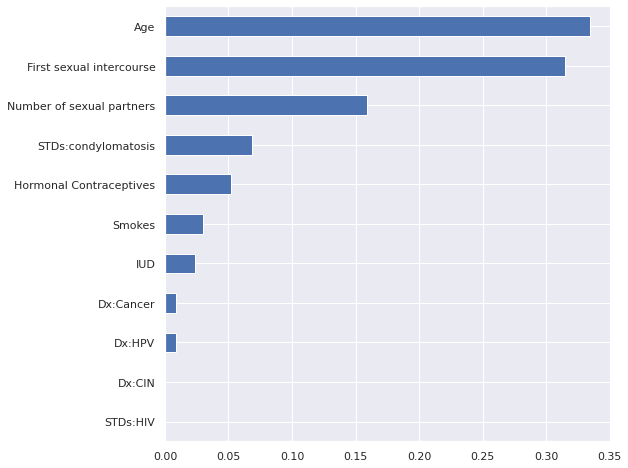

In [68]:
var_imp = pd.DataFrame({'importance': rf_model_tuned.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False);

We will proceed to compute the same metrics for the same methods on a new dataframe DF3 containing `Age`, `First sexual intercourse`, `Number of sexual partners`, `STDs:condylomatosis`, `IUD`, `Smokes`, which seem to be the most relevant variables.

## Results

In [69]:
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.3,0.579,0.499,0.56,0.633
LDA,0.353,0.316,0.805,0.601,0.594,0.612
QDA-0.01,0.353,0.375,0.85,0.645,0.653,0.638
DT-best,0.235,0.242,0.812,0.568,0.569,0.566
Combined-NB-tuned,0.176,0.24,0.857,0.581,0.631,0.567
DT-default,0.176,0.171,0.782,0.523,0.522,0.524
RF-best,0.176,0.146,0.737,0.495,0.498,0.498
extra_trees-best,0.176,0.171,0.782,0.523,0.522,0.524
RF-default,0.118,0.174,0.857,0.548,0.608,0.542
RF-balance,0.118,0.174,0.857,0.548,0.608,0.542


### Testing the best model

In [70]:
X = DF2.iloc[:, :-1]  # Features (all columns except the last one)
y = DF2['Cancer']  # Target variable (last column)

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=40) # Adjust the sampling strategy as needed
X_train, y_train = undersampler.fit_resample(X_train, y_train)

results_test = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

In [71]:
knn = KNeighborsClassifier(n_neighbors=5);
knn = knn.fit(X_train,y_train);

# Predict the target variable for the validation set
y_pred_knn_val = knn.predict(X_val)
results_test.loc['KNN-5-val', :] = compute_metrics(y_val, y_pred_knn_val);
confusion(pd.Series(y_val), pd.Series(y_pred_knn_val))

# Predict the target variable for the test set
y_pred_knn_test = knn.predict(X_test)
results_test.loc['KNN-5-test', :] = compute_metrics(y_test, y_pred_knn_test);
confusion(pd.Series(y_test), pd.Series(y_pred_knn_test))

results_test.sort_values(by='**Recall class 1**',ascending=False)

predicted,0,1
target,,
0,65,51
1,5,12


predicted,0,1
target,,
0,78,38
1,8,9


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5-val,0.706,0.3,0.579,0.499,0.56,0.633
KNN-5-test,0.529,0.281,0.654,0.527,0.549,0.601
